In [1]:
import numpy as np
import matplotlib.pyplot as plt
from FD_Vlasov_supp import *
import importlib
importlib.import_module('mpl_toolkits.mplot3d').__path__
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
import numpy.linalg as la

% matplotlib inline
#np.set_printoptions(precision = 2)

In [25]:
Lv = 20     # approximation to "infinity" for velocity space

k = 0.483
L = 2*np.pi/k  # length of spatial domain, which is periodic


nx = 200
nv = 200

x = np.linspace(0,L,nx)
v = np.linspace(-Lv,Lv,nv)

X,V = np.meshgrid(x,v)  # represent as grid

def central_diff_space(u,x):
    # computes the spatial derivatives via central differences
    # X is entire grid
    # u does not have first column (periodic in x)\
    
    dudx = np.roll(u,-1,axis = 1) - np.roll(u,1,axis = 1)
    x_shift = np.roll(x,-1,axis = 1)
    x_shift[:,-1] = x[:,-1] + x[:,1]
    dx = np.diff(x,axis = 1) + np.diff(x_shift,axis = 1)
    dudx = dudx/(dx)
    return dudx[1:-1,:]

def central_diff_vel(u,v):
    # computes spatial derivative via central difference
    # V is entire grid
    # u does not have first column (periodic)
    
    dudv = np.roll(u,-1,axis = 0) - np.roll(u,1,axis = 0)
    dv = np.roll(v,-1,axis = 0) - np.roll(v,1,axis = 0)
    dudv = dudv/(dv[:,:-1])
    #return dudv
    return dudv[1:-1,:]

def initial_u(x,v):
    z = np.exp(-(v**2)/2)
    z = z/(np.sqrt(2*np.pi)*L)
    return z

def F(t,x,v):
    # from comparison of Eulerian solvers pg.14 - isn't working too well
    alpha = 0.1
    k = 0.483
    if (t == 0):
        # single pulse    
        z = alpha*np.cos(k*x)
    else:
        z = 0*x 
    return 1.0

# change to Adams-Bashforth - unstable
def Forward_Euler_time(u,dt,dudx,dudv,v,F):
    unew = u
    unew -= v*dt*dudx
    unew -= F*dt*dudv
    return unew

def AB2(u,dt,dudx,dudv,dudx_1,dudv_1,v,F,F_1):
    unew = u
    unew += 1.5*dt*(-v*dudx -F*dudv)
    unew -= 0.5*dt*(-v*dudx_1 - F_1*dudv_1)
    return unew

def AB3(u,dt,dudx,dudv,dudx_1,dudv_1,dudx_2,dudv_2,v,F,F_1,F_2):
    unew = u
    unew += (23/12)*dt*(-v*dudx - F*dudv)
    unew -= (4/3)*dt*(-v*dudx_1 - F_1*dudv_1)
    unew += (5/12)*dt*(-v*dudx_2 - F_2*dudv_2)
    return unew

# integrates out velocity for poisson computation
# just need to solve a BVP
def integrate_u(u):
    int_u = np.zeros(nx,)
    
    # assume u has no redundant column
    int_u[1:] = integrate.simps(u,v,axis = 0)
    int_u[0] = int_u[-1]
    
    return int_u


# need an integral of f over v-space function

In [26]:
# internal electric field computation
# assume even spacing for now...
def solve_bvp(U):
    A = np.diag(2*np.ones(nx-2,)) - np.diag(np.ones(nx-3,),-1) - np.diag(np.ones(nx-3,),1)
    A = A/((x[1] - x[0])**2)   # assumes evenly spaced x
    rho = integrate_u(U)
    phi = np.zeros(nx,)
    phi[1:-1] = la.solve(A,rho[1:-1])
    return phi

def compute_electric_field(U):
    dx = x[1] - x[0]
    phi = solve_bvp(U)
    E = -np.gradient(phi,dx,edge_order = 2)
    E = E.reshape(1,-1)
    E = np.repeat(E,nv,axis = 0)
    return E



In [27]:
Uplot = initial_u(X,V)
U = np.delete(Uplot,0,1)
E = compute_electric_field(U)
E.shape

(200, 200)

In [28]:
Uplot.shape

(200, 200)

In [30]:
Uplot = initial_u(X,V)
U = np.delete(Uplot,0,1) # inital condition, remove first column (periodic)
steps = 50
dt = 1/10

dudx_2 = central_diff_space(U,X)
dudv_2 = central_diff_vel(U,V)
E_2 = compute_electric_field(U)
print(U.shape)
print(dudx_2.shape)
print(dudv_2.shape)
print(E_2.shape)
U[1:-1,:] = Forward_Euler_time(U[1:-1,:],dt,dudx_2,dudv_2,V[1:-1,1:],E_2[1:-1,1:])

dudx_1 = central_diff_space(U,X)
dudv_1 = central_diff_vel(U,V)
E_1 = compute_electric_field(U)
U[1:-1,:] = AB2(U[1:-1,:],dt,dudx_1,dudv_1,dudx_2,dudv_2,V[1:-1,1:],E_1[1:-1,1:],E_2[1:-1,1:])

for i in range(2,steps):
    dudx = central_diff_space(U,X)
    dudv = central_diff_vel(U,V)
    E = compute_electric_field(U)
    U[1:-1,:] = AB3(U[1:-1,:],dt,dudx,dudv,dudx_1,dudv_1,dudx_2,dudv_2,V[1:-1,1:],E[1:-1,1:],E_1[1:-1,1:],\
                   E_2[1:-1,1:])
    
    dudx_2 = dudx_1
    dudv_2 = dudv_1
    dudx_1 = dudx
    dudv_1 = dudv
    E_2 = E_1
    E_1 = E
    
    if (i % 10000 == 0):
        Uplot[1:-1,0] = U[1:-1,-1]
        Uplot[1:-1,1:] = U[1:-1,:]
        plt.plot(v,Uplot[:,25])
        plt.show()

(200, 199)
(198, 199)
(198, 199)
(200, 200)


In [31]:
Uplot[1:-1,0] = U[1:-1,-1]
Uplot[1:-1,1:] = U[1:-1,:]

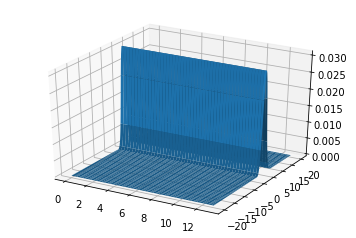

In [32]:
fig = plt.figure(1)
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(X,V,Uplot,antialiased = True,linewidth = 0)

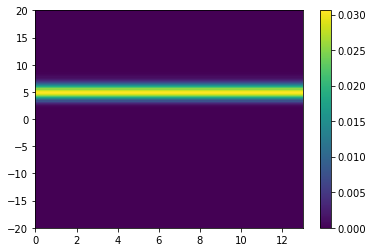

In [33]:
plt.pcolor(X,V,Uplot)
plt.colorbar()

In [ ]:
# old version, no electric field

Uplot = initial_u(X,V)
U = np.delete(Uplot,0,1) # inital condition, remove first column (periodic)
steps = 50
dt = 1/40


dudx_2 = central_diff_space(U,X)
dudv_2 = central_diff_vel(U,V)
U[1:-1,:] = Forward_Euler_time(U[1:-1,:],dt,dudx_2,dudv_2,V[1:-1,1:],F(0,X[1:-1,1:],V))

dudx_1 = central_diff_space(U,X)
dudv_1 = central_diff_vel(U,V)
U[1:-1,:] = AB2(U[1:-1,:],dt,dudx_1,dudv_1,dudx_2,dudv_2,V[1:-1,1:],F(dt,X[1:-1,1:],V),F(0,X[1:-1,1:],V))

for i in range(2,steps):
    dudx = central_diff_space(U,X)
    dudv = central_diff_vel(U,V)
    U[1:-1,:] = AB3(U[1:-1,:],dt,dudx,dudv,dudx_1,dudv_1,dudx_2,dudv_2,V[1:-1,1:],F(i*dt,X[1:-1,1:],V),\
                   F((i-1)*dt,X[1:-1,1:],V),F((i-2)*dt,X[1:-1,1:],V))
    
    dudx_2 = dudx_1
    dudv_2 = dudv_1
    dudx_1 = dudx
    dudv_1 = dudv
    
    if (i % 2 == 0):
        Uplot[1:-1,0] = U[1:-1,-1]
        Uplot[1:-1,1:] = U[1:-1,:]
        plt.plot(v,Uplot[:,25])
        plt.show()

In [ ]:
2 % 5

In [ ]:

Uplot[1:-1,0] = U[1:-1,-1]
Uplot[1:-1,1:] = U[1:-1,:]


In [ ]:
fig = plt.figure(1)
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(X,V,Uplot,antialiased = True,linewidth = 0)
#surf = ax.scatter(X,V,Uplot)

In [ ]:
plt.pcolor(X,V,Uplot)
plt.colorbar()

In [ ]:
plt.plot(Uplot[90,:])

In [ ]:
plt.plot(v,Uplot[:,2])

In [ ]:
X.shape

In [ ]:
np.zeros(5,)

In [2]:
np.arange(1.1,5,0.1)

array([ 1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9])